Подключение библиотек

In [32]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, BaggingRegressor
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, classification_report
from sklearn.pipeline import Pipeline
from imblearn.combine import SMOTETomek
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier, plot_importance
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression


Настройка вывода

In [2]:
pd.set_option('display.max_column', None)

Предобработка данных

In [3]:
train = pd.read_csv('train.csv', low_memory=False)
valid = pd.read_csv('valid.csv', low_memory=False)

train.info()
valid.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14456 entries, 0 to 14455
Columns: 2666 entries, report_date to col2663
dtypes: float64(2316), int64(3), object(347)
memory usage: 294.0+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3642 entries, 0 to 3641
Columns: 2666 entries, report_date to col2663
dtypes: float64(2329), int64(3), object(334)
memory usage: 74.1+ MB


Удаляем столбцы в которых менее 75% заполненых данных

In [4]:
threshold=0.75
train = train.loc[:, (train.notna()).mean() > threshold]
train = train.drop_duplicates()
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14456 entries, 0 to 14455
Columns: 247 entries, report_date to col2663
dtypes: float64(242), int64(3), object(2)
memory usage: 27.2+ MB


удаляем лишние столбцы из valid

In [5]:
valid = valid[train.columns]
valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3642 entries, 0 to 3641
Columns: 247 entries, report_date to col2663
dtypes: float64(242), int64(3), object(2)
memory usage: 6.9+ MB


заполняем пропущенные значения соседними в пределах строки

In [6]:
train = train.groupby('client_id').apply(lambda group: group.fillna(method='ffill').fillna(method='bfill'))
valid = valid.groupby('client_id').apply(lambda group: group.fillna(method='ffill').fillna(method='bfill'))


C:\Users\grigo\AppData\Local\Temp\ipykernel_17200\1198275200.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train = train.groupby('client_id').apply(lambda group: group.fillna(method='ffill').fillna(method='bfill'))
C:\Users\grigo\AppData\Local\Temp\ipykernel_17200\1198275200.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train = train.groupby('client_id').apply(lambda group: group.fillna(method='ffill').fillna(method='bfill'))
C:\Users\grigo\AppData\Local\Temp\ipykernel_17200\1198275200.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.

In [7]:
train = train.drop(['report_date', 'col1454'], axis=1)
valid = valid.drop(['report_date', 'col1454'], axis=1)

In [8]:
total_missing_values = train.isna().sum().sum()
print(total_missing_values)

66194


In [9]:
train = train.fillna(0)
valid = valid.fillna(0)

In [10]:
train.to_csv('clean_train.csv')
valid.to_csv('clean_valid.csv')

In [11]:
clean_train = pd.read_csv('clean_train.csv')
clean_valid = pd.read_csv('clean_valid.csv')
clean_train.info()
clean_valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14456 entries, 0 to 14455
Columns: 247 entries, client_id to col2663
dtypes: float64(242), int64(5)
memory usage: 27.2 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3642 entries, 0 to 3641
Columns: 247 entries, client_id to col2663
dtypes: float64(242), int64(5)
memory usage: 6.9 MB


поготовка данных для обучения 

посмотрим баланс классов

In [12]:
X_train = clean_train.drop(['target'], axis=1)
y_train = clean_train['target']

balance = y_train.value_counts(normalize=True)
print(balance)

target
0    0.96984
1    0.03016
Name: proportion, dtype: float64


используем SMOTETomek для исправления баланса

In [13]:
smote = SMOTETomek(random_state=42)
X_balanced_train, y_balanced_train = smote.fit_resample(X_train, y_train)
class_balance = y_balanced_train.value_counts(normalize=True)

print(y_balanced_train.value_counts(normalize=True))

c:\Users\grigo\PycharmProjects\pythonProject\.venv\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\grigo\PycharmProjects\pythonProject\.venv\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTETomek or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
c:\Users\grigo\PycharmProjects\pythonProject\.venv\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._

target
0    0.5
1    0.5
Name: proportion, dtype: float64


баланс исправлен, теперь определим важные признаки

In [18]:
# 1. Масштабирование данных для PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_balanced_train)

# 2. Применяем PCA
pca = PCA(n_components=0.95)  
X_pca = pca.fit_transform(X_scaled)

# 3. Определяем вклад признаков в каждую компоненту
components = pd.DataFrame(pca.components_, columns=X_balanced_train.columns)

# 4. Определяем признаки, наиболее влияющие на компоненты
important_features = set()
threshold = 0.25  # Порог значимости вклада признака
for component in components.values:
    feature_contributions = np.abs(component)  # Берем абсолютные значения вкладов
    important_features.update(X_balanced_train.columns[feature_contributions > threshold])

# 5. Сохраняем важные признаки в отдельную переменную
important_features = list(important_features)
X_selected = X_balanced_train[important_features]

X_selected.to_csv('features_train.csv', index=False)

print(len(important_features))

75


Создание модели Логистическая регрессия

c:\Users\grigo\PycharmProjects\pythonProject\.venv\Lib\site-packages\sklearn\svm\_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\grigo\PycharmProjects\pythonProject\.venv\Lib\site-packages\sklearn\svm\_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\grigo\PycharmProjects\pythonProject\.venv\Lib\site-packages\sklearn\svm\_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\grigo\PycharmProjects\pythonProject\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative s

Best parameters for Logistic Regression: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
ROC-AUC Score: 0.6419946105348789


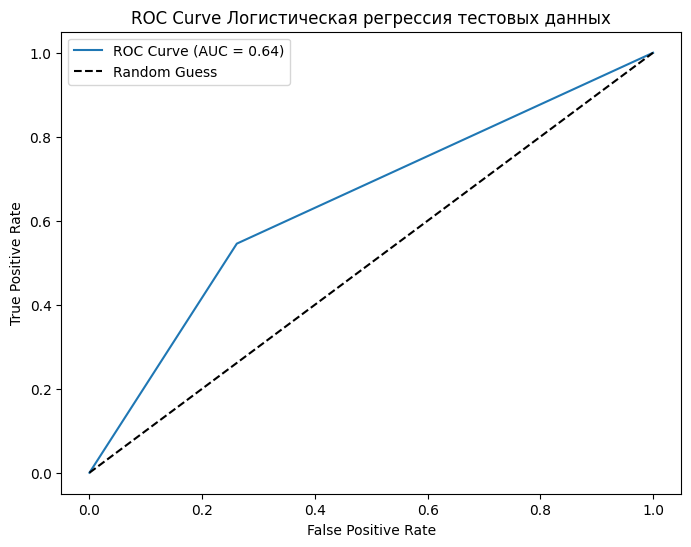

In [25]:
X_train = pd.read_csv('features_train.csv')
y_train = y_balanced_train
X_test = clean_valid.drop(['target'], axis=1)[important_features]
y_test = clean_valid['target']




# Определение параметров для поиска
param_grid_logreg = {
    'C': [0.1,  1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'lbfgs']
}

# Поиск по сетке
grid_search_logreg = GridSearchCV(LogisticRegression(), param_grid_logreg, cv=5, scoring='accuracy')
grid_search_logreg.fit(X_train, y_train)

# Лучшие параметры
print("Best parameters for Logistic Regression:", grid_search_logreg.best_params_)

# Лучшая модель
best_model_logreg = grid_search_logreg.best_estimator_



# предсказание на тестовых данных
y_pred_logreg = best_model_logreg.predict(X_test)

# вычисление ROC-AUC
roc_auc_logreg = roc_auc_score(y_test, y_pred_logreg)
print(f'ROC-AUC Score: {roc_auc_logreg}')

# вывод графика ROC-AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_logreg)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_logreg:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


Создание модели RandomForest

Best parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
ROC-AUC Score: 0.6057809640024405


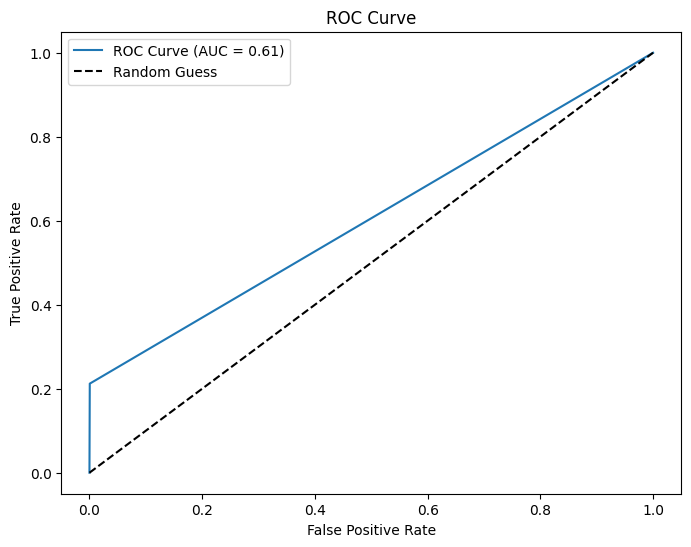

In [28]:
X_train = pd.read_csv('features_train.csv')
y_train = y_balanced_train
X_test = clean_valid.drop(['target'], axis=1)[important_features]
y_test = clean_valid['target']


param_grid_rf = {
    'n_estimators': [100],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10, 15, 20]
}

grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, scoring='accuracy')
grid_search_rf.fit(X_train, y_train)

print("Best parameters for Random Forest:", grid_search_rf.best_params_)
best_model_rf = grid_search_rf.best_estimator_


# предсказание на тестовых данных
y_pred_rf = best_model_rf.predict(X_test)

# вычисление ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_rf)
print(f'ROC-AUC Score: {roc_auc}')

# вывод графика ROC-AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


Модель

ROC-AUC Score: 0.7369627482882516


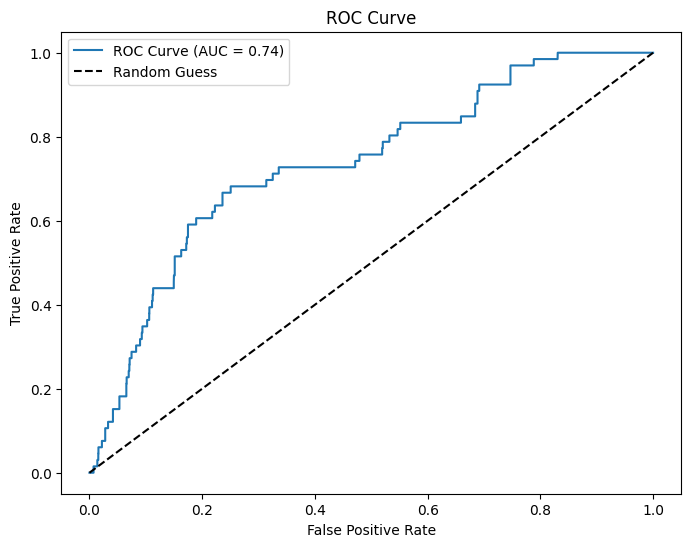

In [40]:
# создание модели регрессии и установка гиперпараметров
base_model = RandomForestRegressor(
     n_estimators=50,       # количество деревьев
     max_depth=10,           # глубина деревьев
     min_samples_split=40,  # минимальное количество образцов для разделения
     min_samples_leaf=20,    # минимальное количество образцов в листе
     random_state=42
)

model = BaggingRegressor(estimator=base_model)
model.fit(X_train, y_train)


# предсказание на тестовых данных
y_pred = model.predict(X_test)



# вычисление ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred)
print(f'ROC-AUC Score: {roc_auc}')

# вывод графика ROC-AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()